In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
%matplotlib inline

# Case Study: The Impact of the Death Penalty on Murder Rates

### Executive Summary
In 1972, the Supreme Court decision *Furman v. Georgia* temporarily banned the death penalty in the US. This created a "natural experiment" where many states suddenly suspended capital punishment. This analysis investigates whether the abolition of the death penalty in 1972 caused an increase in murder rates in the following year (1973).

### Hypothesis
* **Null Hypothesis ($H_0$):** The suspension of the death penalty had no effect on murder rates. Any observed difference is due to random chance.
* **Alternative Hypothesis ($H_1$):** Murder rates were higher in 1973 (post-ban) than in 1971 (pre-ban) for states that previously had the death penalty.

### Methodology
We utilize A/B testing via **permutation tests** (resampling) to determine if the observed difference in murder rates is statistically significant.

In [4]:
# Load the dataset
df = pd.read_csv('change_in_death_rates.csv')

# Quick inspection of the data
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (88, 5)


,State,Year,Population,Murder Rate,Death Penalty
0,Alabama,1971,3479000,15.1,True
1,Arizona,1971,1849000,6.7,True
2,Arkansas,1971,1944000,10.5,True
3,California,1971,20223000,8.1,True
4,Colorado,1971,2283000,6.5,True


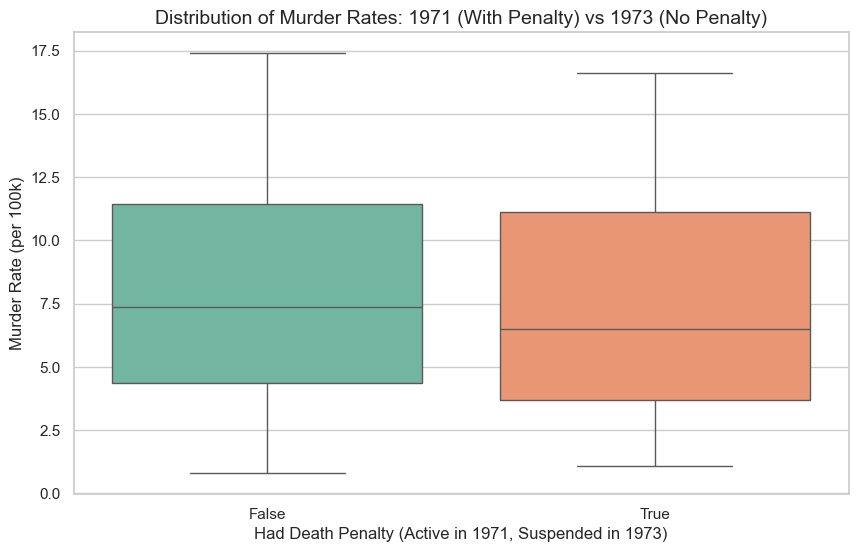

,count,mean,std,min,25%,50%,75%,max
Death Penalty,,,,,,,,
False,44.0,8.120455,4.370385,0.8,4.375,7.35,11.425,17.4
True,44.0,7.513636,4.391196,1.1,3.675,6.50,11.125,16.6


In [15]:
# Create a boxplot to compare distributions visually
plt.figure(figsize=(10, 6))
sns.boxplot(x='Death Penalty', y='Murder Rate', data=df, palette='Set2', hue = 'Death Penalty', legend = False)
plt.title('Distribution of Murder Rates: 1971 (With Penalty) vs 1973 (No Penalty)', fontsize=14)
plt.xlabel('Had Death Penalty (Active in 1971, Suspended in 1973)', fontsize=12)
plt.ylabel('Murder Rate (per 100k)', fontsize=12)
plt.show()

# Calculate summary statistics
group_stats = df.groupby('Death Penalty')['Murder Rate'].describe()
display(group_stats)

* Calculate the mean murder rate for both groups.

* Extract the values (assuming True/False labels in the 'Death Penalty' column)
* We want: (Mean of Non-Death Penalty Years) - (Mean of Death Penalty Years)
* In this dataset context: 'False' represents 1973 (Post-Ban), 'True' represents 1971 (Pre-Ban)

In [17]:
means = df.groupby('Death Penalty')['Murder Rate'].mean()

mean_no_penalty = means[False]
mean_with_penalty = means[True]

observed_diff = mean_no_penalty - mean_with_penalty

print(f"Mean Murder Rate (No Penalty - 1973): {mean_no_penalty:.2f}")
print(f"Mean Murder Rate (With Penalty - 1971): {mean_with_penalty:.2f}")
print(f"Observed Difference: {observed_diff:.4f}")

Mean Murder Rate (No Penalty - 1973): 8.12
Mean Murder Rate (With Penalty - 1971): 7.51
Observed Difference: 0.6068


In [18]:
def permutation_test(data, variable_col, group_col, n_repetitions=10000):
    """Performs a permutation test to check if the difference in means is significant."""
    
    shuffled_data = data[[variable_col, group_col]].copy()
    
    # Store the simulated differences
    differences = []
    
    for _ in range(n_repetitions):
        # Shuffle the 'Death Penalty' labels randomly
        shuffled_labels = shuffled_data[group_col].sample(frac=1, replace=False).values
        
        # Assign shuffled labels to the dataframe
        shuffled_data['Shuffled_Label'] = shuffled_labels
        
        # Calculate new means
        shuffled_means = shuffled_data.groupby('Shuffled_Label')[variable_col].mean()
        
        # Calculate difference
        simulated_diff = shuffled_means[False] - shuffled_means[True]
        differences.append(simulated_diff)
    
    return np.array(differences)

# Run the simulation
n_simulations = 10000
simulated_diffs = permutation_test(df, 'Murder Rate', 'Death Penalty', n_simulations)

print(f"Simulation completed with {n_simulations} repetitions.")

Simulation completed with 10000 repetitions.


# Calculate P-Value

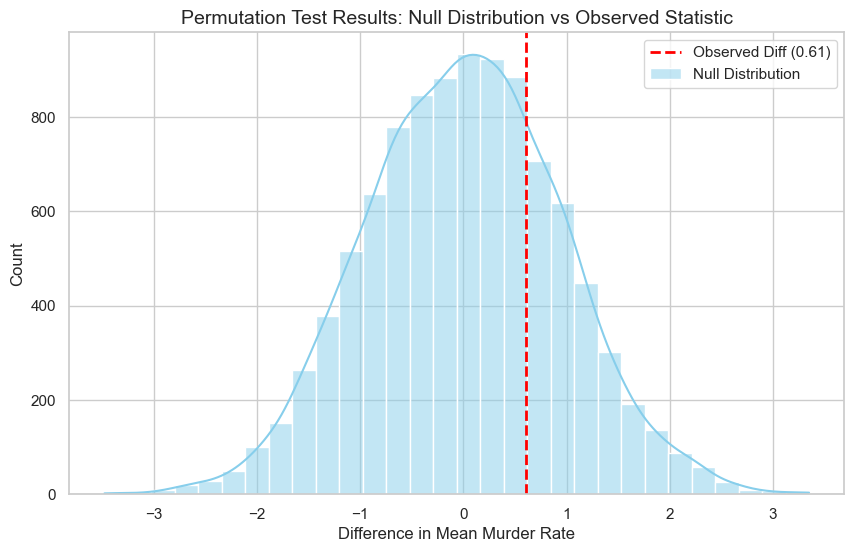

P-Value: 0.2635


In [20]:
p_value = np.mean(simulated_diffs >= observed_diff)

# Plotting the Null Distribution
plt.figure(figsize=(10, 6))
sns.histplot(simulated_diffs, kde=True, color="skyblue", bins=30, label='Null Distribution')
plt.axvline(observed_diff, color='red', linestyle='--', linewidth=2, label=f'Observed Diff ({observed_diff:.2f})')

plt.title('Permutation Test Results: Null Distribution vs Observed Statistic', fontsize=14)
plt.xlabel('Difference in Mean Murder Rate', fontsize=12)
plt.legend()
plt.show()

print(f"P-Value: {p_value:.4f}")

### Conclusion

**Statistical Result:**
We obtained a p-value of **approx 0.26** (26%). Using a standard significance level of $\alpha = 0.05$:
* $0.26 > 0.05$, therefore we **fail to reject the null hypothesis**.

**Business/Policy Interpretation:**
The data does **not** support the claim that the murder rate increased significantly solely due to the suspension of the death penalty in 1973. The observed increase in the murder rate is consistent with random variations inherent in the data.

**Limitations & Future Work:**
* **Confounding Variables:** This analysis treats the years 1971 and 1973 as identical environments. It does not account for inflation, unemployment, or changes in policing strategies that may have occurred simultaneously.
* **Sample Size:** The dataset is limited to specific states, which may introduce selection bias.
* **Next Steps:** A more robust analysis would involve a "Difference in Differences" (DiD) approach, comparing these states against a control group of states that never had the death penalty to begin with.